# Loading Multi-photon Calcium Imaging Data

Cellular Calcium activity recorded using a multi-photon imaging.

## Relevant ALF objects
* mpci
* mpciROIs
* mpciROITypes
* mpciMeanImage
* mpciStack

## Terminology
* **ROI** - A region of interest, usually a neuron soma, detected using an algorithm such as Suite2P.
* **FOV** - A field of view is a plane or volume covering a region of the brain.
* **Imaging stack** - Multiple FOVs acquired at different depths along the same z axis.

## Finding sessions with imaging data
Sessions that contain any form of imaging data have an 'Imaging' procedure. This includes sessions
photometry, mesoscope, 2P, and widefield data.  To further filter by imaging modality you can query
the imaging type associated with a session's field of view.

In [1]:
# Find mesoscope imaging sessions
from one.api import ONE
one = ONE()
assert not one.offline, 'ONE must be connect to Alyx for searching imaging sessions'

query = 'field_of_view__imaging_type__name,mesoscope'
eids = one.search(procedures='Imaging', django=query, query_type='remote')

Sessions can be further filtered by brain region.  You can filter with by Allen atlas name, acronym
or ID, for example:

* `atlas_name='Primary visual area'`
* `atlas_acronym='VISp'`
* `atlas_id=385`

In [2]:
# Find mesoscope imaging sessions in V1, layer 2/3
query = 'field_of_view__imaging_type__name,mesoscope'
eids = one.search(procedures='Imaging', django=query, query_type='remote', atlas_acronym='VISp2/3')

The 'details' flag will return the session details, including a `field_of_view` field which contains
a list of each field of view and its location.  All preprocessed mpci imaging data is in `alf/FOV_XX`
where XX is the field of view number. The `FOV_XX` corresponds to a field of view name in Alyx.

In [3]:
eids = one.search(procedures='Imaging', django=query, query_type='remote', atlas_acronym='VISp1')
det = one.get_details(eids[0], full=True)
FOVs = det['field_of_view']
print(FOVs[0])

{'id': '5d210d00-9fa1-475e-9183-5af3fc6f9281', 'imaging_type': 'mesoscope', 'location': [{'id': '863feb81-635d-4be8-9aea-801fe17cdec9', 'brain_region': [593, 805], 'coordinate_system': 'IBL-Allen', 'provenance': 'E', 'x': [1524.224038768259, 2211.2735781060705, 1412.8068358620303, 2125.853722544629], 'y': [-3604.2337950500123, -3604.233795050006, -4304.2087950500145, -4304.208795050008], 'z': [-7.466537406952739, -174.58305699938734, -286.00954467253143, -388.1326959029978], 'n_xyz': [512, 512, 1], 'default_provenance': True, 'auto_datetime': '2024-06-27T15:08:48.904000'}], 'name': 'FOV_00', 'session': '23d5eb2a-05dc-442c-8a48-40e426088a4d', 'stack': None, 'datasets': ['edc0bbe3-5677-4578-a95f-e47998a81f03', '67825957-6ea7-4780-9693-19bbc04952e9', 'efd517c8-d004-45b7-8624-49a871fc4d96', '249e769d-9c4f-4be5-bff2-48f466d40e5b', '5dd53fb1-0658-4c04-bfc0-4045c2228198', 'd5df8a9c-9b77-428c-a404-d19dfa0faefc', '4e4c259e-8c69-431b-8eac-8178efb5f7ea', 'f25645fc-b3b6-40cd-b2db-4fe6b5a3d7b1', '7

The ibllib AllenAtlas class allows you to search brain region descendents and ancestors in order to
find the IDs of brain regions at a certain granularity.

In [4]:
# Search brain areas by name using Alyx
V1 = one.alyx.rest('brain-regions', 'list', name='Primary visual area')
for area in V1:
    print('%s (%s: %i)' % (area['name'], area['acronym'], area['id']))


from iblatlas.atlas import AllenAtlas
atlas = AllenAtlas()

# Interconvert ID and acronym
V1_id = atlas.regions.acronym2id('VISp')
V1_acronym = atlas.regions.id2acronym(V1_id)

# Show all descendents of primary visual area (i.e. all layers)
atlas.regions.descendants(V1_id)

Primary visual area (VISp: 385)
Primary visual area layer 1 (VISp1: 593)
Primary visual area layer 2/3 (VISp2/3: 821)
Primary visual area layer 4 (VISp4: 721)
Primary visual area layer 5 (VISp5: 778)
Primary visual area layer 6a (VISp6a: 33)
Primary visual area layer 6b (VISp6b: 305)


{'id': array([385, 593, 821, 721, 778,  33, 305], dtype=int64),
 'name': array(['Primary visual area', 'Primary visual area layer 1',
        'Primary visual area layer 2/3', 'Primary visual area layer 4',
        'Primary visual area layer 5', 'Primary visual area layer 6a',
        'Primary visual area layer 6b'], dtype=object),
 'acronym': array(['VISp', 'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b'],
       dtype=object),
 'rgb': array([[  8, 133, 140],
        [  8, 133, 140],
        [  8, 133, 140],
        [  8, 133, 140],
        [  8, 133, 140],
        [  8, 133, 140],
        [  8, 133, 140]], dtype=uint8),
 'level': array([7, 8, 8, 8, 8, 8, 8], dtype=uint16),
 'parent': array([669., 385., 385., 385., 385., 385., 385.]),
 'order': array([185, 186, 187, 188, 189, 190, 191], dtype=uint16)}

For more information see "[Working with ibllib atlas](./atlas_working_with_ibllib_atlas.html)".

## Loading imaging data for a given field of view

For mesoscope sessions there are likely more than one field of view, not all of which cover the
area of interest.  For mesoscope sessions it's therefore more useful to search by field of view instead.
Each field of view returned contains a session eid for loading data with.

In [5]:
# Search for all mesoscope fields of view containing V1
FOVs = one.alyx.rest('fields-of-view', 'list', imaging_type='mesoscope', atlas_acronym='VISp')
# Download all data for the first field of view
FOV_00  = one.load_collection(FOVs[0]['session'], '*' + FOVs[0]['name'])

# Search the fields of view for a specific session that took place in a given brain region
eid = '748f3e27-5097-4b1b-a535-5940aaa52909'
FOVs = one.alyx.rest('fields-of-view', 'list', imaging_type='mesoscope', atlas_id=281, session=eid)

## Loading imaging stacks
For mesoscope sessions the same region may be acquired at multiple depths.  The plane at each depth
is considered a separate field of view and are related to one another through the stack object.
If a field of view was acquired as part of a stack, the `stack` field will contain an ID. You can
find all fields of view in a given stack by querying the 'imaging-stack' endpoint:

In [6]:
stack = one.alyx.rest('imaging-stack', 'read', id=FOVs[0]['stack'])
FOVs = stack['slices']
print('There were %i fields of view in stack %s' % (len(FOVs), stack['id']))

There were 2 fields of view in stack 0458ac46-5841-47c5-8a3c-2782052e6d0b


### List the number of fields of view (FOVs) recorded during a session

In [7]:
from one.api import ONE
one = ONE()
eid = '009aad6f-1881-46ca-b763-bc4ec8972692'

fov_folders = one.list_collections(eid, collection='alf/FOV_*')
fovs = sorted(map(lambda x: int(x[-2:]), fov_folders))
nFOV = len(fovs)

## Loading ROI activity for a single session

In [8]:
# Loading ROI activity for a single FOV
objects = ['mpci', 'mpciROIs', 'mpciROITypes', 'mpciStack']
ROI_data_00 = one.load_collection(eid, 'alf/FOV_00', object=objects)
print(ROI_data_00.keys())

# Loading ROI activity for all FOVs
from iblutil.util import Bunch
all_ROI_data = Bunch()
for fov in fov_folders:
    all_ROI_data[fov.split('/')[-1]] = one.load_collection(eid, fov, object=objects)
print(all_ROI_data.keys())
print(all_ROI_data.FOV_00.keys())

dict_keys(['mpciROITypes', 'mpciROIs', 'mpci', 'mpciStack'])
dict_keys(['FOV_04', 'FOV_02', 'FOV_07', 'FOV_06', 'FOV_03', 'FOV_00', 'FOV_05', 'FOV_01'])
dict_keys(['mpciROITypes', 'mpciROIs', 'mpci', 'mpciStack'])


### Get the brain location of an ROI
The brain location of each ROI are first estimated using the surgical coordinates of the imaging window.
These datasets have an '_estimate' in the name.  After histological alignment, datasets are created
without '_estimate' in the name.  The histologically aligned locations are most accurate and should be
used where available.

In [9]:
roi = 0  # The ROI index to lookup
final_alignment =  'brainLocationsIds_ccf_2017' in ROI_data_00['mpciROIs']
key = 'brainLocationsIds_ccf_2017' if final_alignment else 'brainLocationIds_ccf_2017_estimate'

atlas_id = ROI_data_00['mpciROIs'][key][roi]
print(f'ROI {roi} was located in {atlas.regions.id2acronym(atlas_id)}')

ROI 0 was located in ['RSPd1']


## Loading times
Timestamps for each frame are in seconds from session start and represent the time when frame acquisition started.
Typically a laser scans each voxel in the field of view in a line by line fashion (this may vary across apparatus and
in configuarations such as dual plane mode).  Thus there is a fixed time offset between regions of interest.
The offset can be found in the mpciStack.timeshift.npy dataset and depending on its shape, may be per voxel or per
scan line.

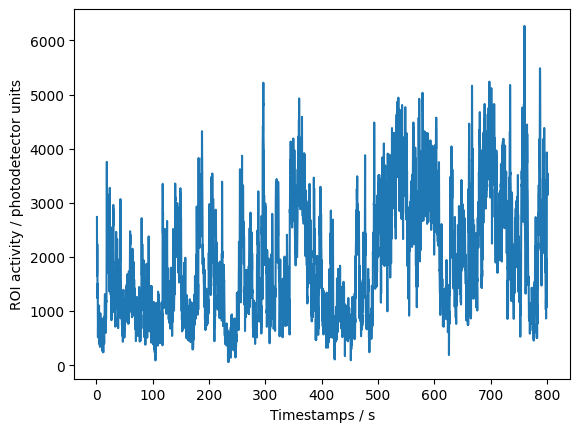

In [10]:
frame_times = ROI_data_00['mpci']['times']
roi_xyz = ROI_data_00['mpciROIs']['stackPos']
timeshift = ROI_data_00['mpciStack']['timeshift']
roi_offsets = timeshift[roi_xyz[:, len(timeshift.shape)]]
# An array of timestamps of shape (n_roi, n_frames)
import numpy as np
roi_times = np.tile(frame_times, (roi_offsets.size, 1)) + roi_offsets[np.newaxis, :].T

import matplotlib.pyplot as plt
roi_signal = ROI_data_00['mpci']['ROIActivityF'].T
roi = 2  # The ROI index to lookup
plt.plot(roi_times[roi], roi_signal[roi])
plt.xlabel('Timestamps / s'), plt.ylabel('ROI activity / photodetector units');

### Search for sessions with multi-depth fields of view (imaging stacks)

In [11]:
query = 'field_of_view__stack__isnull,False'
eids, det = one.search(procedures='Imaging', django=query, query_type='remote', details=True)

### Search sessions with GCaMP mice
...

## More details
* [Description of mesoscope datasets](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.nvzaz0fozs8h)
* [Loading raw mesoscope data](./loading_raw_mesoscope_data.ipynb)